In [1]:
import os
import sys
import subprocess
import pkg_resources


def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])


# List of required packages
required_packages = ['ipywidgets', 'jupyter', 'matplotlib', 'numpy',
                     'optuna-integration[sklearn]', 'optuna',  'pandas', 'scikit-learn']

# Check if packages are installed, and install if not
for package in required_packages:
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        install(package)

# Check if the environment is activated
if 'CONDA_DEFAULT_ENV' in os.environ:
    print(f"Environment '{os.environ['CONDA_DEFAULT_ENV']}' is activated.")
else:
    print("No specific environment is activated.")

Environment 'research' is activated.


In [2]:
import numpy as np
import pandas as pd
from IPython.display import display

np.random.seed(42)

In [3]:
# # Load the store sales dataset
# excel_file = pd.ExcelFile('data/store_sales.xlsx')
# sheet_names = excel_file.sheet_names

# # Read the data
# results_df = pd.read_excel(excel_file, sheet_name=sheet_names[2])  # 2, 9
# iri_key_counts = results_df['IRI_KEY'].value_counts()
# iri_keys = iri_key_counts[iri_key_counts > 300].index


# features = ['F', 'D', 'Unit.Price']
# target = ['Total.Volume']

# results_df = results_df[results_df['IRI_KEY'] == iri_keys[0]]
# X = results_df[features]
# y = results_df[target]

# sheet_names, iri_keys, X.shape, y.shape

In [4]:
# Load the California housing dataset
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

X = pd.DataFrame(housing.data, columns=housing.feature_names)  # type: ignore
y = pd.DataFrame(housing.target, columns=housing.target_names)  # type: ignore

X.shape, y.shape

((20640, 8), (20640, 1))

In [5]:
# # Load the soybean dataset
# raw_df = pd.read_excel("data/soybean.xlsx")
# # X = raw_df.values[:-1, [5, 6, 15, 16, 17, 26,
# #                         34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]]  # 9 check yield 12 rm band
# # y = raw_df.values[:-1, 11]
# X = raw_df.iloc[:-1, [5, 6, 15, 16, 17, 26,
#                   34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]]
# y = raw_df.iloc[:-1, [11]]
# X.shape, y.shape

In [6]:
# # Define the data
# data = {
#     "Size": [850, 900, 1200, 1400, 1600, 1700, 1800, 2000, 2200, 2500],
#     "Bedrooms": [2, 3, 3, 3, 3, 4, 4, 4, 5, 5],
#     "Price": [300, 340, 400, 500, 520, 580, 600, 620, 720, 790]
# }

# df = pd.DataFrame(data)

# X = df[["Size", "Bedrooms"]]
# y = df[["Price"]]
# X.shape, y.shape

In [7]:
display(X, y)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422
...,...
20635,0.781
20636,0.771
20637,0.923
20638,0.847


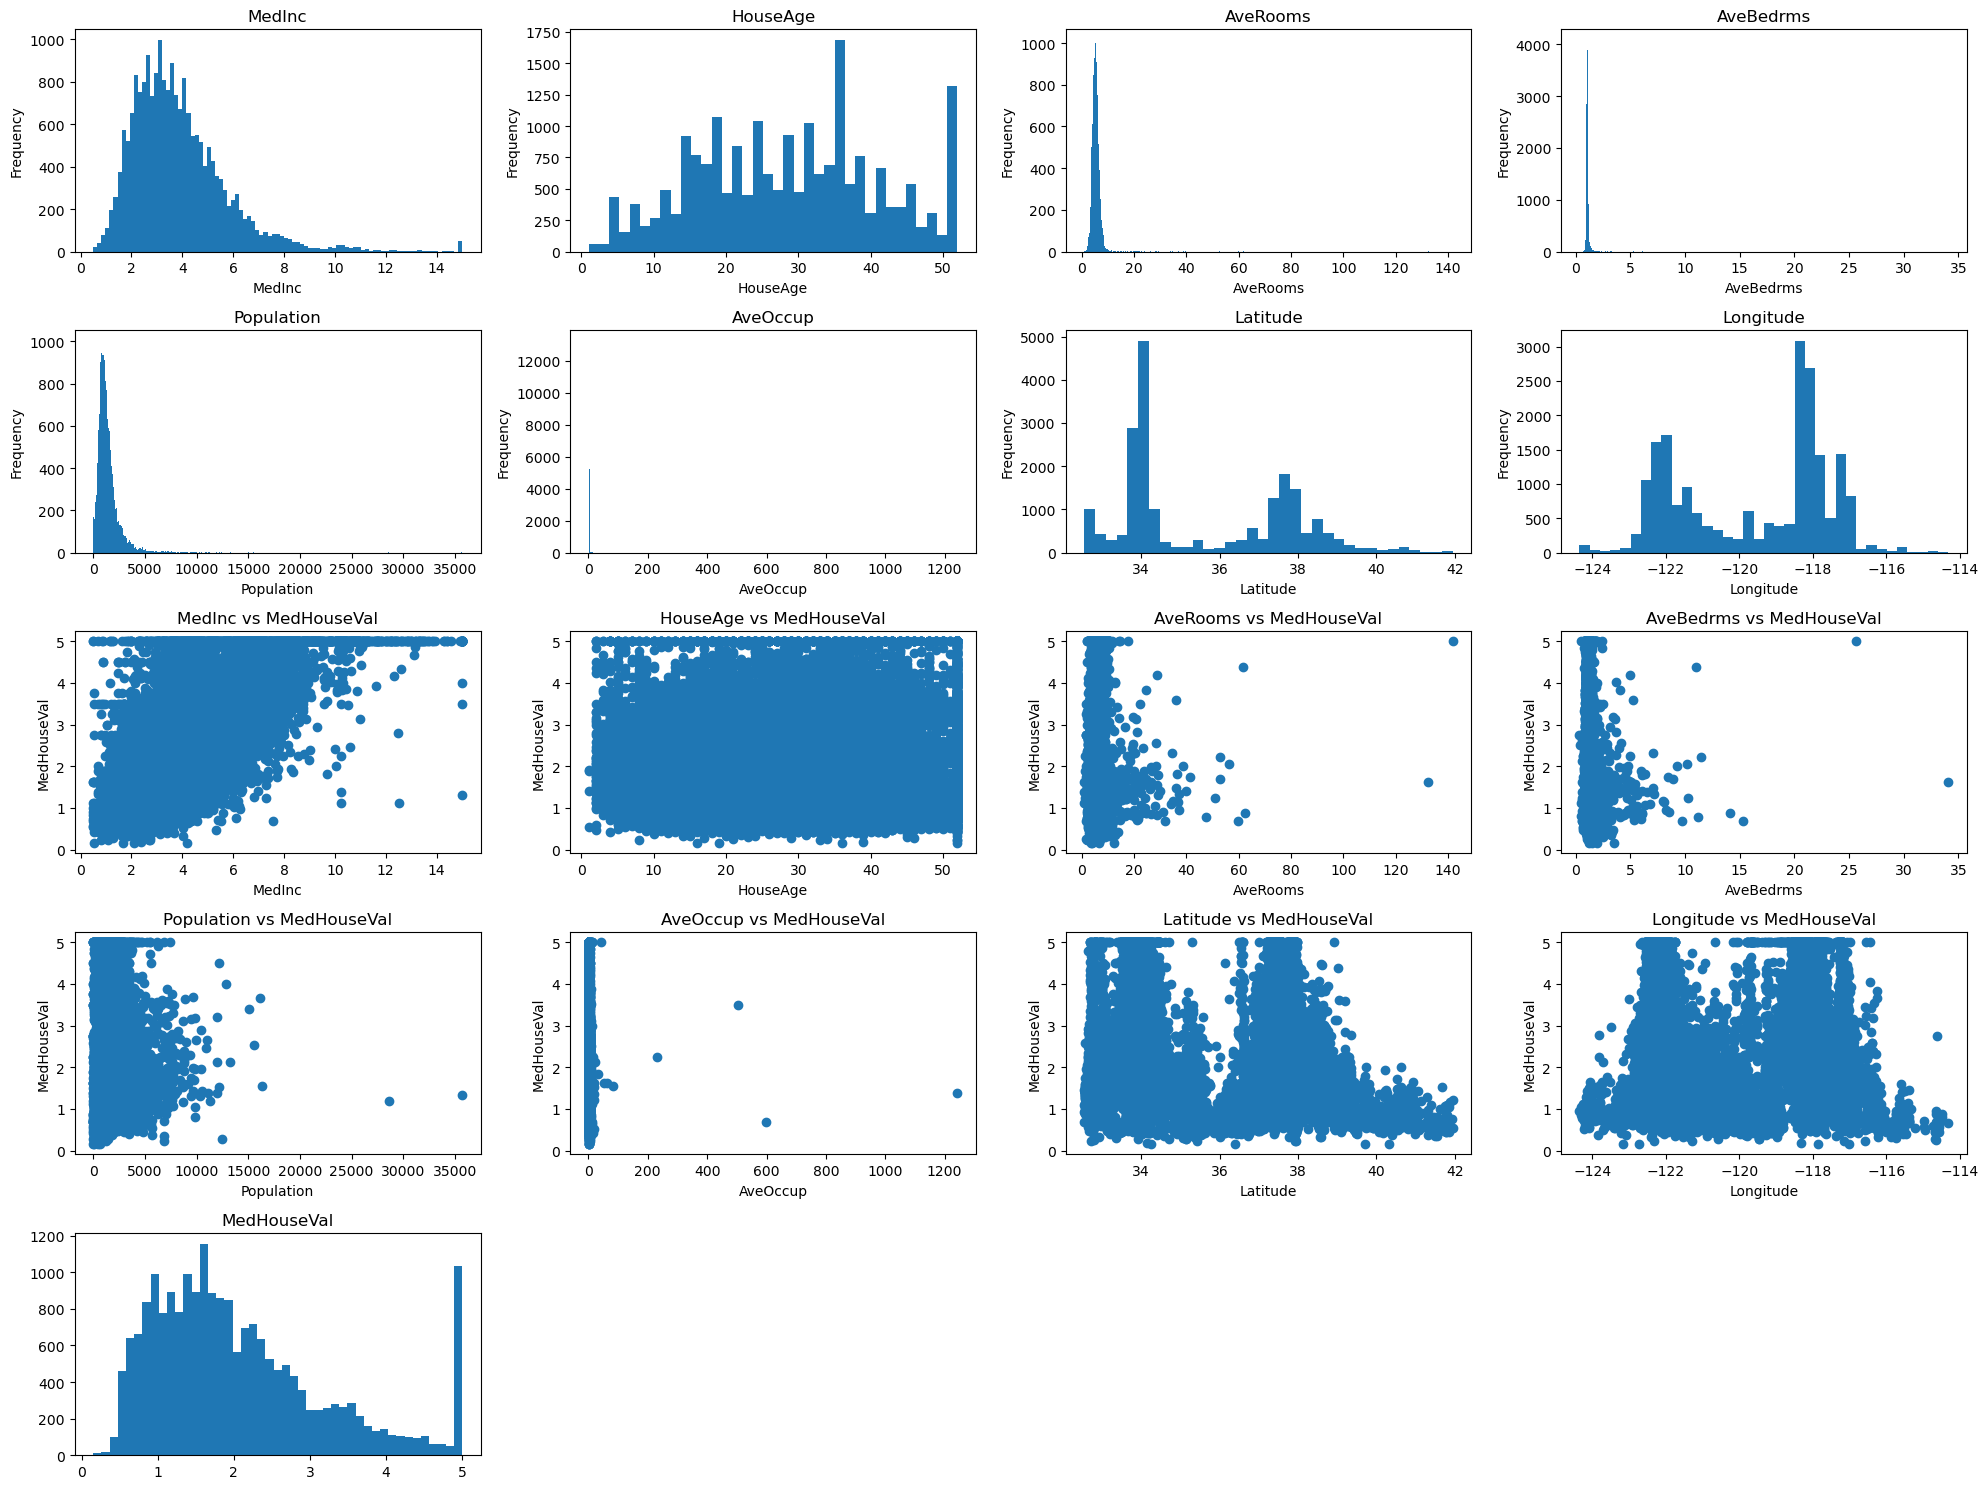

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


,MedHouseVal
count,20640.000000
mean,2.068558
std,1.153956
min,0.149990
25%,1.196000
50%,1.797000
75%,2.647250
max,5.000010


In [8]:
# Plot Data
import matplotlib.pyplot as plt

cols = 4
fig, axs = plt.subplots(
    (2*X.shape[1] + y.shape[1]+cols-1)//cols, cols, figsize=(20, 15))
axs = axs.flatten()


def bins(data):
    IQR = np.percentile(data, 75) - np.percentile(data, 25)
    bin_width = 2 * IQR * len(data) ** (-1/3)
    n_bins = int((np.max(data) - np.min(data)) / bin_width)
    return min(max(n_bins, 10), 1000)


a = 0
for i, col in enumerate(X.columns):
    data = X[col]
    axs[a+i].hist(data, bins=bins(data))
    axs[a+i].set_title(col)
    axs[a+i].set_xlabel(col)
    axs[a+i].set_ylabel('Frequency')
a += i + 1
for i, col in enumerate(X.columns):
    data = X[col]
    axs[a+i].scatter(data, y.iloc[:, 0], )
    axs[a+i].set_title(f'{col} vs {y.columns[0]}')
    axs[a+i].set_xlabel(col)
    axs[a+i].set_ylabel(y.columns[0])
a += i + 1
for i, col in enumerate(y.columns):
    data = y[col]
    axs[a+i].hist(data, bins=bins(data))
    axs[a+i].set_title(col)
a += i+1
for k in range(a, len(axs)):
    fig.delaxes(axs[k])

plt.tight_layout()
plt.show()
display(X.describe(), y.describe())

In [9]:
from optuna.integration.sklearn import OptunaSearchCV
from optuna import distributions
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, QuantileTransformer

SCALERS = {
    'identity': FunctionTransformer(func=None, inverse_func=None),
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'quantile': QuantileTransformer(),
}

search_params = {
    'cv': 5,
    'n_jobs': 1,  # -1,
    'n_trials': 10,
    # 'n_trials': None,
    'random_state': 42,
    'return_train_score': True,
    'scoring': 'neg_root_mean_squared_error',
    # 'timeout': 10,
    'timeout': None,
    'verbose': 1
}

mlp_sk_param_grid = {
    'learning_rate_init': distributions.FloatDistribution(1e-3, 1e-1, log=True),
    'max_iter': distributions.CategoricalDistribution([100]),
    'early_stopping': distributions.CategoricalDistribution([True]),
    # 'max_iter': distributions.IntDistribution(200, 1000, log=True),
}
mlp_param_grid = {
    'learning_rate': distributions.FloatDistribution(1e-3, 1e-1, log=True),
    'epochs': distributions.CategoricalDistribution([100]),
    # 'epochs': distributions.IntDistribution(200, 1000, log=True),
}


def search(model, param_grid={}, scaler=SCALERS['identity'], search_params=search_params):
    return OptunaSearchCV(Pipeline([('scaler', scaler), ('model', model)]), {f'model__{k}': v for k, v in param_grid.items()}, **search_params)
    # return OptunaSearchCV(model, param_grid, **search_params)

In [10]:
from models_sklearn import Tree, Ensemble, MLP_sk, FONN1_sk, FONN2_sk, TREENN1_sk, TREENN2_sk
from models import MLP, FONN1, FONN2, TREENN1, TREENN2

models = {}

num_trees_input = 5
num_trees_hidden = 5
# hidden_nodes = [10]
hidden_nodes = [5, 10]

scalers = ['identity', 'standard']

models['Tree'] = search(Tree())
for hn in hidden_nodes:
    for scaler in scalers:
        models[f'MLP_sk_{scaler} {hn}'] = search(
            MLP_sk(hn), mlp_sk_param_grid, SCALERS[scaler])
        models[f'MLP_sk_tanh_{scaler} {hn}'] = search(
            MLP_sk(hn, activation='tanh'), mlp_sk_param_grid, SCALERS[scaler])
        models[f'Ensemble_sk_{scaler} {hn}'] = search(Ensemble(hn))
        models[f'FONN1_sk_{scaler} {num_trees_input} {hn}'] = search(
            FONN1_sk(num_trees_input, num_trees_input+hn), mlp_sk_param_grid, SCALERS[scaler])
        models[f'FONN2_sk_{scaler} {num_trees_hidden} {hn}'] = search(
            FONN2_sk(hn, num_trees_hidden+hn), mlp_sk_param_grid, SCALERS[scaler])

# if isinstance(hn, tuple):
    #     models[f'Ensemble {sum(hn)}'] = search(Ensemble(sum(hn)))
    #     models[f'FONN1_sk {num_trees_input} {hn}'] = search(
    #         FONN1_sk(num_trees_input, (num_trees_input+hn[0], *hn[1:])), mlp_sk_param_grid)
    #     models[f'FONN2_sk {num_trees_hidden} {hn}'] = search(
    #         FONN2_sk(num_trees_hidden, (*hn[:-1], num_trees_hidden+hn[-1])), mlp_sk_param_grid)
    #     models[f'TREENN1_sk {hn}'] = search(
    #         TREENN1_sk((1+hn[0], *hn[1:])), mlp_sk_param_grid)
    #     models[f'TREENN2_sk {hn}'] = search(
    #         TREENN2_sk((*hn[:-1], 1+hn[-1])), mlp_sk_param_grid)

input_dim = X.shape[1]
output_dim = 1

# for hn in hidden_nodes:
#     models[f'MLP {hn}'] = search(
#         MLP(input_dim, hn, output_dim), mlp_param_grid)
#     models[f'MLP_tanh {hn}'] = search(
#         MLP(input_dim, hn, output_dim, activation='tanh'), mlp_param_grid)
#     models[f'FONN1 {num_trees_input} {hn}'] = search(
#         FONN1(input_dim, hn, output_dim, num_trees_input), mlp_param_grid)
#     models[f'FONN2 {num_trees_hidden} {hn}'] = search(
#         FONN2(input_dim, hn, output_dim, num_trees_hidden), mlp_param_grid)
#     models[f'TREENN1 {hn}'] = search(
#         FONN1(input_dim, hn, output_dim, 1), mlp_param_grid)
#     models[f'TREENN2 {hn}'] = search(
#         FONN2(input_dim, hn, output_dim, 1), mlp_param_grid)

models

/tmp/ipykernel_342247/2001946657.py:40: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(Pipeline([('scaler', scaler), ('model', model)]), {f'model__{k}': v for k, v in param_grid.items()}, **search_params)


{'Tree': OptunaSearchCV(cv=5,
                estimator=Pipeline(steps=[('scaler', FunctionTransformer()),
                                          ('model', Tree())]),
                n_jobs=1, param_distributions={}, random_state=42,
                return_train_score=True, scoring='neg_root_mean_squared_error',
                verbose=1),
 'MLP_sk_identity 5': OptunaSearchCV(cv=5,
                estimator=Pipeline(steps=[('scaler', FunctionTransformer()),
                                          ('model',
                                           MLP_sk(hidden_layer_sizes=5))]),
                n_jobs=1,
                param_distributions={'model__early_stopping': CategoricalDistribution(choices=(True,)),
                                     'model__learning_rate_init': FloatDistribution(high=0.1, log=True, low=0.001, step=None),
                                     'model__max_iter': CategoricalDistribution(choices=(100,))},
                random_state=42, return_train_score=

In [11]:
import os
import sys
from warnings import simplefilter
if not sys.warnoptions:
    simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

# Train and evaluate models
cv_results = {}
results = []

result_columns = [
    'mean_fit_time', 'mean_score_time', 'mean_train_score', 'mean_test_score'
]


def fit_model(name, model, X, y):
    print(f"Fitting {name}...")
    model.fit(X, y)
    result = model.cv_results_
    cv_results[name] = result
    return {
        'model': name,
        **{col: result[col][model.best_index_] for col in result}
    }


for name, model in models.items():
    results.append(fit_model(name, model, X, y))

results_df = pd.DataFrame(results)
results_df.set_index('model', inplace=True)
results_df = results_df[result_columns]
display(results_df)

[I 2024-11-16 19:56:10,837] A new study created in memory with name: no-name-83e6f305-9f8d-448f-8aa1-e6afe93b41c5


Fitting Tree...


[I 2024-11-16 19:56:11,397] Trial 0 finished with value: -0.9035989438053121 and parameters: {}. Best is trial 0 with value: -0.9035989438053121.
[I 2024-11-16 19:56:11,916] Trial 1 finished with value: -0.926979681563737 and parameters: {}. Best is trial 0 with value: -0.9035989438053121.
[I 2024-11-16 19:56:12,453] Trial 2 finished with value: -0.8946250967639401 and parameters: {}. Best is trial 2 with value: -0.8946250967639401.
[I 2024-11-16 19:56:12,988] Trial 3 finished with value: -0.9384823600660749 and parameters: {}. Best is trial 2 with value: -0.8946250967639401.
[I 2024-11-16 19:56:13,509] Trial 4 finished with value: -0.9207326716840102 and parameters: {}. Best is trial 2 with value: -0.8946250967639401.
[I 2024-11-16 19:56:14,026] Trial 5 finished with value: -0.9085611938395569 and parameters: {}. Best is trial 2 with value: -0.8946250967639401.
[I 2024-11-16 19:56:14,543] Trial 6 finished with value: -0.9114467850464522 and parameters: {}. Best is trial 2 with value: 

Fitting MLP_sk_identity 5...


[I 2024-11-16 19:56:19,536] Trial 0 finished with value: -0.9124967990742352 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.9124967990742352.
[I 2024-11-16 19:56:22,037] Trial 1 finished with value: -1.0042292668568722 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.9124967990742352.
[I 2024-11-16 19:56:29,150] Trial 2 finished with value: -0.8725000651382573 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 2 with value: -0.8725000651382573.
[I 2024-11-16 19:56:33,224] Trial 3 finished with value: -0.9652919439410141 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 2 with value: -0.8725000651382573.

Fitting MLP_sk_tanh_identity 5...


[I 2024-11-16 19:57:03,471] Trial 0 finished with value: -1.1237154230636772 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -1.1237154230636772.
[I 2024-11-16 19:57:04,239] Trial 1 finished with value: -1.1689536941081222 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -1.1237154230636772.
[I 2024-11-16 19:57:05,861] Trial 2 finished with value: -1.1742968802224847 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -1.1237154230636772.
[I 2024-11-16 19:57:06,913] Trial 3 finished with value: -1.1734235196593847 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -1.1237154230636772.

Fitting Ensemble_sk_identity 5...


[I 2024-11-16 19:57:20,807] Trial 0 finished with value: -0.7106167633931391 and parameters: {}. Best is trial 0 with value: -0.7106167633931391.
[I 2024-11-16 19:57:23,363] Trial 1 finished with value: -0.6990062293901883 and parameters: {}. Best is trial 1 with value: -0.6990062293901883.
[I 2024-11-16 19:57:25,881] Trial 2 finished with value: -0.7278111820773783 and parameters: {}. Best is trial 1 with value: -0.6990062293901883.
[I 2024-11-16 19:57:28,410] Trial 3 finished with value: -0.7127084464227159 and parameters: {}. Best is trial 1 with value: -0.6990062293901883.
[I 2024-11-16 19:57:30,926] Trial 4 finished with value: -0.7077178215249285 and parameters: {}. Best is trial 1 with value: -0.6990062293901883.
[I 2024-11-16 19:57:36,383] Trial 5 finished with value: -0.7086595232516887 and parameters: {}. Best is trial 1 with value: -0.6990062293901883.
[I 2024-11-16 19:57:38,910] Trial 6 finished with value: -0.7151388902164937 and parameters: {}. Best is trial 1 with value:

Fitting FONN1_sk_identity 5 5...


[I 2024-11-16 19:57:53,187] Trial 0 finished with value: -0.7945452260956308 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.7945452260956308.
[I 2024-11-16 19:57:59,286] Trial 1 finished with value: -0.7549996604950546 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.7549996604950546.
[I 2024-11-16 19:58:06,538] Trial 2 finished with value: -0.7406413157166918 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 2 with value: -0.7406413157166918.
[I 2024-11-16 19:58:15,745] Trial 3 finished with value: -0.7981274492249634 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 2 with value: -0.7406413157166918.

Fitting FONN2_sk_identity 5 5...


[I 2024-11-16 19:59:09,080] Trial 0 finished with value: -2.157031906966859 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -2.157031906966859.
[I 2024-11-16 19:59:21,546] Trial 1 finished with value: -1.1653457101803584 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -1.1653457101803584.
[I 2024-11-16 19:59:41,276] Trial 2 finished with value: -1.8305745933416382 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -1.1653457101803584.
[I 2024-11-16 19:59:56,615] Trial 3 finished with value: -1.3096437327238994 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -1.1653457101803584.
[

Fitting MLP_sk_standard 5...


[I 2024-11-16 20:01:38,288] Trial 0 finished with value: -0.6738986545305162 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.6738986545305162.
[I 2024-11-16 20:01:39,622] Trial 1 finished with value: -0.6534505458960562 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.6534505458960562.
[I 2024-11-16 20:01:43,640] Trial 2 finished with value: -0.6712237395075593 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.6534505458960562.
[I 2024-11-16 20:01:47,438] Trial 3 finished with value: -0.6595201525425216 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.6534505458960562.

Fitting MLP_sk_tanh_standard 5...


[I 2024-11-16 20:02:15,006] Trial 0 finished with value: -0.642043575067202 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.642043575067202.
[I 2024-11-16 20:02:16,424] Trial 1 finished with value: -0.6507540919461086 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.642043575067202.
[I 2024-11-16 20:02:20,302] Trial 2 finished with value: -0.6495828354430107 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.642043575067202.
[I 2024-11-16 20:02:24,026] Trial 3 finished with value: -0.6357867299983463 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 3 with value: -0.6357867299983463.
[I 

Fitting Ensemble_sk_standard 5...


[I 2024-11-16 20:02:52,228] Trial 0 finished with value: -0.7210352153306607 and parameters: {}. Best is trial 0 with value: -0.7210352153306607.
[I 2024-11-16 20:02:54,724] Trial 1 finished with value: -0.7068011968792836 and parameters: {}. Best is trial 1 with value: -0.7068011968792836.
[I 2024-11-16 20:02:57,230] Trial 2 finished with value: -0.712986636429992 and parameters: {}. Best is trial 1 with value: -0.7068011968792836.
[I 2024-11-16 20:02:59,736] Trial 3 finished with value: -0.7094921698700892 and parameters: {}. Best is trial 1 with value: -0.7068011968792836.
[I 2024-11-16 20:03:02,246] Trial 4 finished with value: -0.7140143650060121 and parameters: {}. Best is trial 1 with value: -0.7068011968792836.
[I 2024-11-16 20:03:04,760] Trial 5 finished with value: -0.7118263098050628 and parameters: {}. Best is trial 1 with value: -0.7068011968792836.
[I 2024-11-16 20:03:10,194] Trial 6 finished with value: -0.7137185092534128 and parameters: {}. Best is trial 1 with value: 

Fitting FONN1_sk_standard 5 5...


[I 2024-11-16 20:03:22,909] Trial 0 finished with value: -0.7310872250073979 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.7310872250073979.
[I 2024-11-16 20:03:26,544] Trial 1 finished with value: -0.7258307367142709 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.7258307367142709.
[I 2024-11-16 20:03:32,985] Trial 2 finished with value: -0.748465241188179 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.7258307367142709.
[I 2024-11-16 20:03:38,006] Trial 3 finished with value: -0.7429370755236822 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.7258307367142709.


Fitting FONN2_sk_standard 5 5...


[I 2024-11-16 20:04:22,065] Trial 0 finished with value: -0.7968827215541392 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.7968827215541392.
[I 2024-11-16 20:04:27,406] Trial 1 finished with value: -1.4308590968870811 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.7968827215541392.
[I 2024-11-16 20:04:37,347] Trial 2 finished with value: -0.8471632495422219 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.7968827215541392.
[I 2024-11-16 20:04:44,334] Trial 3 finished with value: -0.8120964193892396 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.7968827215541392.

Fitting MLP_sk_identity 10...


[I 2024-11-16 20:05:43,749] Trial 0 finished with value: -0.907863629748675 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.907863629748675.
[I 2024-11-16 20:05:45,614] Trial 1 finished with value: -1.3674469497987196 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.907863629748675.
[I 2024-11-16 20:05:50,277] Trial 2 finished with value: -0.9763954225978353 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.907863629748675.
[I 2024-11-16 20:05:53,822] Trial 3 finished with value: -0.8477748110467835 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 3 with value: -0.8477748110467835.
[I 

Fitting MLP_sk_tanh_identity 10...


[I 2024-11-16 20:06:18,051] Trial 0 finished with value: -1.055109326992638 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -1.055109326992638.
[I 2024-11-16 20:06:18,778] Trial 1 finished with value: -1.1655916641691904 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -1.055109326992638.
[I 2024-11-16 20:06:20,643] Trial 2 finished with value: -1.1111348548382136 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -1.055109326992638.
[I 2024-11-16 20:06:23,478] Trial 3 finished with value: -0.961368632133963 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 3 with value: -0.961368632133963.
[I 20

Fitting Ensemble_sk_identity 10...


[I 2024-11-16 20:06:44,574] Trial 0 finished with value: -0.6810639017191873 and parameters: {}. Best is trial 0 with value: -0.6810639017191873.
[I 2024-11-16 20:06:49,530] Trial 1 finished with value: -0.68348820432976 and parameters: {}. Best is trial 0 with value: -0.6810639017191873.
[I 2024-11-16 20:06:54,490] Trial 2 finished with value: -0.6764210330166597 and parameters: {}. Best is trial 2 with value: -0.6764210330166597.
[I 2024-11-16 20:06:59,466] Trial 3 finished with value: -0.6939849686305393 and parameters: {}. Best is trial 2 with value: -0.6764210330166597.
[I 2024-11-16 20:07:04,426] Trial 4 finished with value: -0.6878523381422259 and parameters: {}. Best is trial 2 with value: -0.6764210330166597.
[I 2024-11-16 20:07:09,358] Trial 5 finished with value: -0.7006364419941998 and parameters: {}. Best is trial 2 with value: -0.6764210330166597.
[I 2024-11-16 20:07:17,225] Trial 6 finished with value: -0.6807177764151002 and parameters: {}. Best is trial 2 with value: -

Fitting FONN1_sk_identity 5 10...


[I 2024-11-16 20:07:38,840] Trial 0 finished with value: -0.9591838439855639 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.9591838439855639.
[I 2024-11-16 20:07:43,706] Trial 1 finished with value: -0.7600468239424171 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.7600468239424171.
[I 2024-11-16 20:07:53,818] Trial 2 finished with value: -0.8799592864940518 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.7600468239424171.
[I 2024-11-16 20:07:59,557] Trial 3 finished with value: -0.7812373045701226 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.7600468239424171.

Fitting FONN2_sk_identity 5 10...


[I 2024-11-16 20:08:55,114] Trial 0 finished with value: -3.7452440573107717 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -3.7452440573107717.
[I 2024-11-16 20:09:09,787] Trial 1 finished with value: -2.018840054494821 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -2.018840054494821.
[I 2024-11-16 20:09:39,916] Trial 2 finished with value: -2.190204459470735 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -2.018840054494821.
[I 2024-11-16 20:10:02,680] Trial 3 finished with value: -1.39873249426332 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 3 with value: -1.39873249426332.
[I 2024

Fitting MLP_sk_standard 10...


[I 2024-11-16 20:12:26,723] Trial 0 finished with value: -0.6411638614648123 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.6411638614648123.
[I 2024-11-16 20:12:28,763] Trial 1 finished with value: -0.653554654990758 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.6411638614648123.
[I 2024-11-16 20:12:35,990] Trial 2 finished with value: -0.647690114486748 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.6411638614648123.
[I 2024-11-16 20:12:39,367] Trial 3 finished with value: -0.6251587707446079 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 3 with value: -0.6251587707446079.
[

Fitting MLP_sk_tanh_standard 10...


[I 2024-11-16 20:13:08,966] Trial 0 finished with value: -0.6218751120005321 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.6218751120005321.
[I 2024-11-16 20:13:10,878] Trial 1 finished with value: -0.6488396672124088 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.6218751120005321.
[I 2024-11-16 20:13:15,451] Trial 2 finished with value: -0.643273744314558 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.6218751120005321.
[I 2024-11-16 20:13:18,853] Trial 3 finished with value: -0.6384194540607377 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.6218751120005321.


Fitting Ensemble_sk_standard 10...


[I 2024-11-16 20:13:53,226] Trial 0 finished with value: -0.6762518720752995 and parameters: {}. Best is trial 0 with value: -0.6762518720752995.
[I 2024-11-16 20:13:58,158] Trial 1 finished with value: -0.6852765932666494 and parameters: {}. Best is trial 0 with value: -0.6762518720752995.
[I 2024-11-16 20:14:03,089] Trial 2 finished with value: -0.6778775797691601 and parameters: {}. Best is trial 0 with value: -0.6762518720752995.
[I 2024-11-16 20:14:08,025] Trial 3 finished with value: -0.6919106150588868 and parameters: {}. Best is trial 0 with value: -0.6762518720752995.
[I 2024-11-16 20:14:12,946] Trial 4 finished with value: -0.6844686312337258 and parameters: {}. Best is trial 0 with value: -0.6762518720752995.
[I 2024-11-16 20:14:20,808] Trial 5 finished with value: -0.6882385239849574 and parameters: {}. Best is trial 0 with value: -0.6762518720752995.
[I 2024-11-16 20:14:25,738] Trial 6 finished with value: -0.6774268398157967 and parameters: {}. Best is trial 0 with value:

Fitting FONN1_sk_standard 5 10...


[I 2024-11-16 20:14:47,297] Trial 0 finished with value: -0.7394086529936086 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.7394086529936086.
[I 2024-11-16 20:14:54,173] Trial 1 finished with value: -0.7234284283466217 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.7234284283466217.
[I 2024-11-16 20:14:59,900] Trial 2 finished with value: -0.7260044778809845 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 1 with value: -0.7234284283466217.
[I 2024-11-16 20:15:05,814] Trial 3 finished with value: -0.7209899985731576 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 3 with value: -0.7209899985731576.

Fitting FONN2_sk_standard 5 10...


[I 2024-11-16 20:15:55,681] Trial 0 finished with value: -0.904909903361153 and parameters: {'model__learning_rate_init': 0.008117122579380914, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.904909903361153.
[I 2024-11-16 20:16:08,763] Trial 1 finished with value: -1.6564106339658609 and parameters: {'model__learning_rate_init': 0.04626622490126816, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 0 with value: -0.904909903361153.
[I 2024-11-16 20:16:24,106] Trial 2 finished with value: -0.8338380275558555 and parameters: {'model__learning_rate_init': 0.0013743668829195004, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 2 with value: -0.8338380275558555.
[I 2024-11-16 20:16:35,526] Trial 3 finished with value: -0.7864580527913001 and parameters: {'model__learning_rate_init': 0.0043540609288734745, 'model__max_iter': 100, 'model__early_stopping': True}. Best is trial 3 with value: -0.7864580527913001.
[I

,mean_fit_time,mean_score_time,mean_train_score,mean_test_score
model,,,,
Tree,0.101394,0.002125,-0.446370,-0.894625
MLP_sk_identity 5,1.394140,0.002032,-0.794168,-0.804600
MLP_sk_tanh_identity 5,0.380654,0.001580,-1.090653,-1.101823
Ensemble_sk_identity 5,0.495025,0.004086,-0.253676,-0.699006
FONN1_sk_identity 5 5,1.427762,0.006331,-0.310478,-0.740641
FONN2_sk_identity 5 5,2.489403,0.001293,-1.179532,-1.165346
MLP_sk_standard 5,0.263019,0.001490,-0.595746,-0.653451
MLP_sk_tanh_standard 5,0.740036,0.001649,-0.579651,-0.635787
Ensemble_sk_standard 5,0.485320,0.003888,-0.252078,-0.697024


In [12]:
results_df.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_train_score,mean_test_score
model,,,,
MLP_sk_standard 10,0.621844,0.001664,-0.568795,-0.618799
MLP_sk_tanh_standard 10,1.218473,0.001702,-0.550954,-0.621875
MLP_sk_tanh_standard 5,0.740036,0.001649,-0.579651,-0.635787
MLP_sk_standard 5,0.263019,0.001490,-0.595746,-0.653451
Ensemble_sk_standard 10,0.958071,0.006348,-0.220087,-0.669264
Ensemble_sk_identity 10,0.964703,0.006345,-0.217970,-0.676421
Ensemble_sk_standard 5,0.485320,0.003888,-0.252078,-0.697024
Ensemble_sk_identity 5,0.495025,0.004086,-0.253676,-0.699006
FONN1_sk_standard 5 10,1.135837,0.004405,-0.227392,-0.716936


In [13]:
results_df.sort_values(by='mean_train_score', ascending=False)

,mean_fit_time,mean_score_time,mean_train_score,mean_test_score
model,,,,
Ensemble_sk_identity 10,0.964703,0.006345,-0.217970,-0.676421
Ensemble_sk_standard 10,0.958071,0.006348,-0.220087,-0.669264
FONN1_sk_standard 5 10,1.135837,0.004405,-0.227392,-0.716936
FONN1_sk_standard 5 5,0.709181,0.004449,-0.245199,-0.725831
Ensemble_sk_standard 5,0.485320,0.003888,-0.252078,-0.697024
Ensemble_sk_identity 5,0.495025,0.004086,-0.253676,-0.699006
FONN1_sk_identity 5 5,1.427762,0.006331,-0.310478,-0.740641
FONN1_sk_identity 5 10,1.374387,0.005595,-0.319456,-0.756044
Tree,0.101394,0.002125,-0.446370,-0.894625


In [44]:
# [(name, model.best_params_) for name, model in models.items()]
display(pd.DataFrame({name: model.best_params_ for name, model in models.items()}).transpose())

,model__learning_rate_init,model__max_iter,model__early_stopping
Tree,NaN,NaN,NaN
MLP_sk_identity 5,0.004336,100,True
MLP_sk_tanh_identity 5,0.003949,100,True
Ensemble_sk_identity 5,NaN,NaN,NaN
FONN1_sk_identity 5 5,0.001374,100,True
FONN2_sk_identity 5 5,0.046266,100,True
MLP_sk_standard 5,0.046266,100,True
MLP_sk_tanh_standard 5,0.004354,100,True
Ensemble_sk_standard 5,NaN,NaN,NaN
FONN1_sk_standard 5 5,0.046266,100,True


In [39]:
# for name, cv_result in cv_results.items():
#     display(name, pd.DataFrame(cv_result))

In [38]:
# Predictions
predictions = pd.DataFrame({name: model.best_estimator_.predict(X) for name, model in models.items()})
display(predictions)
predictions.describe()

,Tree,MLP_sk_identity 5,MLP_sk_tanh_identity 5,Ensemble_sk_identity 5,FONN1_sk_identity 5 5,FONN2_sk_identity 5 5,MLP_sk_standard 5,MLP_sk_tanh_standard 5,Ensemble_sk_standard 5,FONN1_sk_standard 5 5,...,MLP_sk_identity 10,MLP_sk_tanh_identity 10,Ensemble_sk_identity 10,FONN1_sk_identity 5 10,FONN2_sk_identity 5 10,MLP_sk_standard 10,MLP_sk_tanh_standard 10,Ensemble_sk_standard 10,FONN1_sk_standard 5 10,FONN2_sk_standard 5 10
0,4.52600,2.054295,2.097947,4.3526,4.415754,-0.565339,4.370868,4.252362,4.4260,4.391107,...,4.128229,2.064467,4.250400,4.348682,2.101555,4.071902,4.330784,4.330000,4.264102,4.630563
1,5.00001,2.054295,2.097947,3.8744,3.444098,1.798222,4.527948,4.671552,4.1036,4.206158,...,4.017791,2.064467,3.851500,4.177020,3.251109,4.394572,4.643985,3.733701,4.066909,3.996561
2,3.52100,2.054295,2.097947,3.6518,3.539955,-0.565339,4.368014,3.884752,3.6898,3.795870,...,3.684256,2.064467,3.799701,3.467737,1.833524,4.053712,4.204734,3.489400,3.686896,4.279508
3,3.41300,2.054295,2.097947,3.4130,3.471339,1.462667,3.675971,3.592918,3.5378,3.995976,...,3.207853,2.064467,3.496400,3.245000,1.163896,3.425274,3.471140,3.243700,3.593219,3.724254
4,3.42200,2.054295,2.097947,2.4024,3.142665,1.477897,2.827792,2.802708,3.2318,3.017174,...,2.290146,2.064467,3.075000,2.679753,0.947049,2.697981,2.823626,2.983000,2.346539,2.584627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,0.78100,2.054295,2.097947,0.7810,0.454226,2.087861,0.872900,0.800420,0.7564,0.794516,...,0.760781,2.064467,0.776100,0.831302,1.434529,0.700890,0.948721,0.739300,0.783704,0.588779
20636,0.77100,2.054295,2.097947,0.7252,0.555301,-0.565339,1.043982,0.803635,0.7418,0.697790,...,1.378695,2.064467,0.781300,0.685642,2.470311,1.061446,1.070602,0.719100,0.801451,0.774726
20637,1.00500,2.054295,2.097947,0.8596,0.585155,-0.413583,1.030796,0.925241,0.8150,0.924514,...,0.684318,2.064467,0.855600,1.074779,1.072797,0.844858,1.063580,0.901200,0.829368,0.655917
20638,0.84700,2.054295,2.097947,1.1052,0.600750,1.245423,1.050495,0.994896,0.9156,0.834761,...,0.769751,2.064467,0.833600,1.007981,1.058014,0.880922,1.067281,0.833600,0.878838,0.712903


,Tree,MLP_sk_identity 5,MLP_sk_tanh_identity 5,Ensemble_sk_identity 5,FONN1_sk_identity 5 5,FONN2_sk_identity 5 5,MLP_sk_standard 5,MLP_sk_tanh_standard 5,Ensemble_sk_standard 5,FONN1_sk_standard 5 5,...,MLP_sk_identity 10,MLP_sk_tanh_identity 10,Ensemble_sk_identity 10,FONN1_sk_identity 5 10,FONN2_sk_identity 5 10,MLP_sk_standard 10,MLP_sk_tanh_standard 10,Ensemble_sk_standard 10,FONN1_sk_standard 5 10,FONN2_sk_standard 5 10
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,...,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,2.063155,2.052521,2.095872,2.071043,2.062373,1.566267,2.135167,2.085692,2.069530,2.096577,...,2.171815,2.060086,2.072623,2.026622,2.044803,2.062348,2.087552,2.072073,2.065404,2.073243
std,1.147514,0.019830,0.035013,1.094190,1.143820,3.586785,1.011115,1.002875,1.093359,1.143302,...,0.852387,0.067329,1.087945,1.137098,2.385263,0.976039,0.995298,1.087554,1.130115,0.935112
min,0.149990,0.869151,1.803862,0.250000,-5.406340,-29.637559,0.104754,-0.078920,0.204992,0.223315,...,-9.160454,0.476345,0.335592,-2.611461,-5.799049,0.035513,-0.298782,0.353200,0.025564,-4.630544
25%,1.200000,2.054295,2.097947,1.241750,1.202325,-0.565339,1.372891,1.352824,1.245200,1.227616,...,1.634019,2.064467,1.254375,1.176739,1.149807,1.335040,1.383719,1.241450,1.201486,1.502923
50%,1.791000,2.054295,2.097947,1.834400,1.856462,1.017902,1.842023,1.901629,1.834600,1.847165,...,2.076502,2.064467,1.835300,1.760572,1.756692,1.858446,1.900307,1.837900,1.814740,1.951260
75%,2.649000,2.054295,2.097947,2.642700,2.659870,3.055901,2.762593,2.658586,2.635200,2.704784,...,2.575104,2.064467,2.639625,2.621888,2.343580,2.628433,2.628321,2.637850,2.643389,2.510666
max,5.000010,2.054295,2.461064,5.000010,6.540258,81.829593,7.337126,6.184812,5.000010,5.361906,...,7.677017,2.688948,5.000010,7.336535,37.123869,8.127895,5.765281,5.000010,5.239256,8.465279


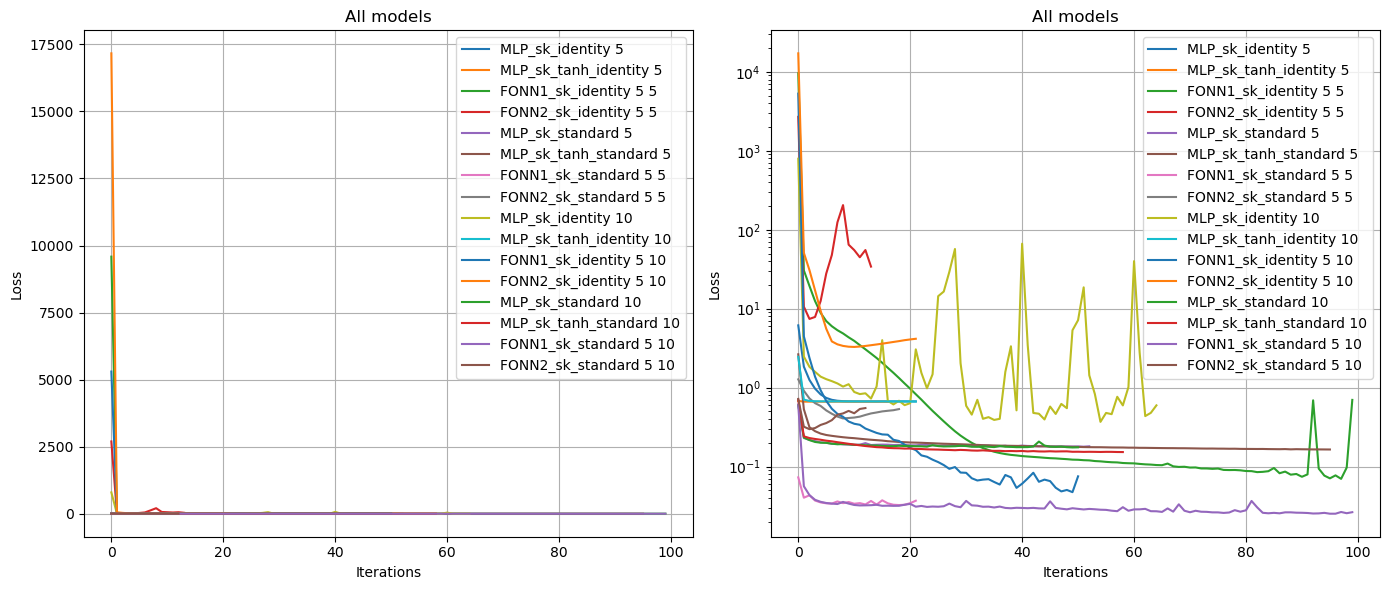

In [ ]:
import matplotlib.pyplot as plt


def plot_loss(model, ax1, ax2, label):
    ax1.plot(model.loss_curve_, label=label)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(model.loss_curve_, label=label)
    ax2.set_yscale('log')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for model_name, model in models.items():
    if hasattr(model.best_estimator_['model'], 'loss_curve_'):
        plot_loss(model.best_estimator_['model'], ax1, ax2, label=model_name)

ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('All models')
ax1.legend()
ax1.grid(True)

ax2.set_yscale('log')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')
ax2.set_title('All models')
ax2.legend()
ax2.grid(True)

fig.tight_layout()
fig.show()

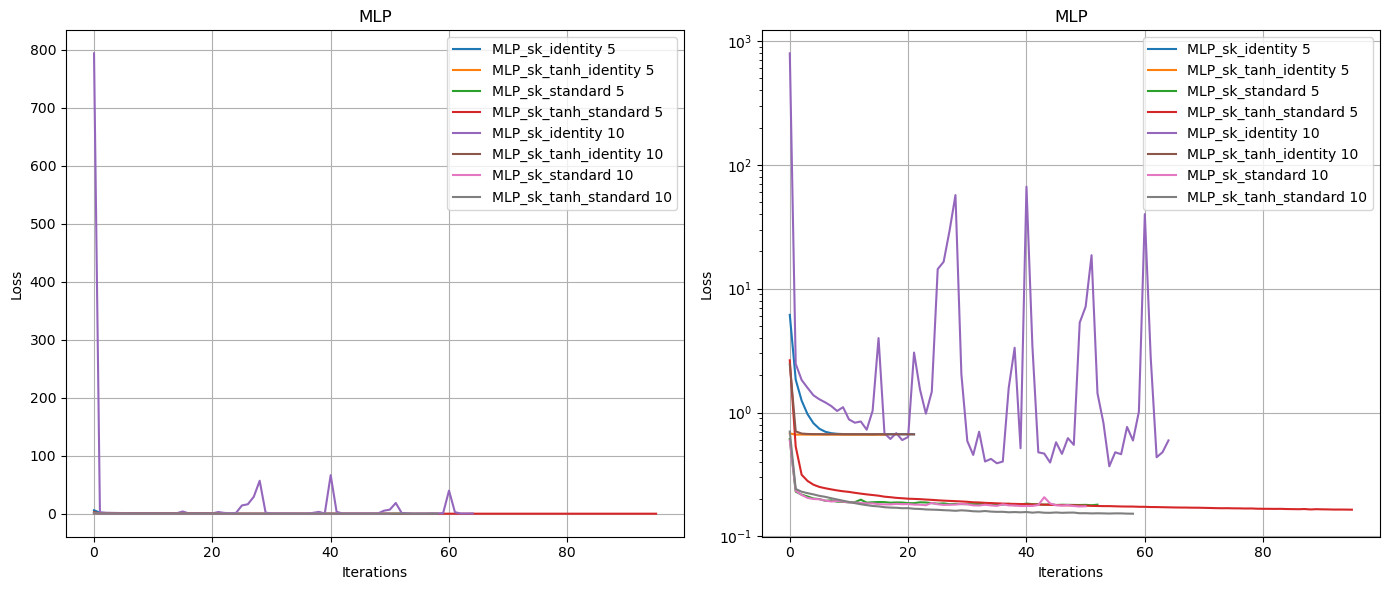

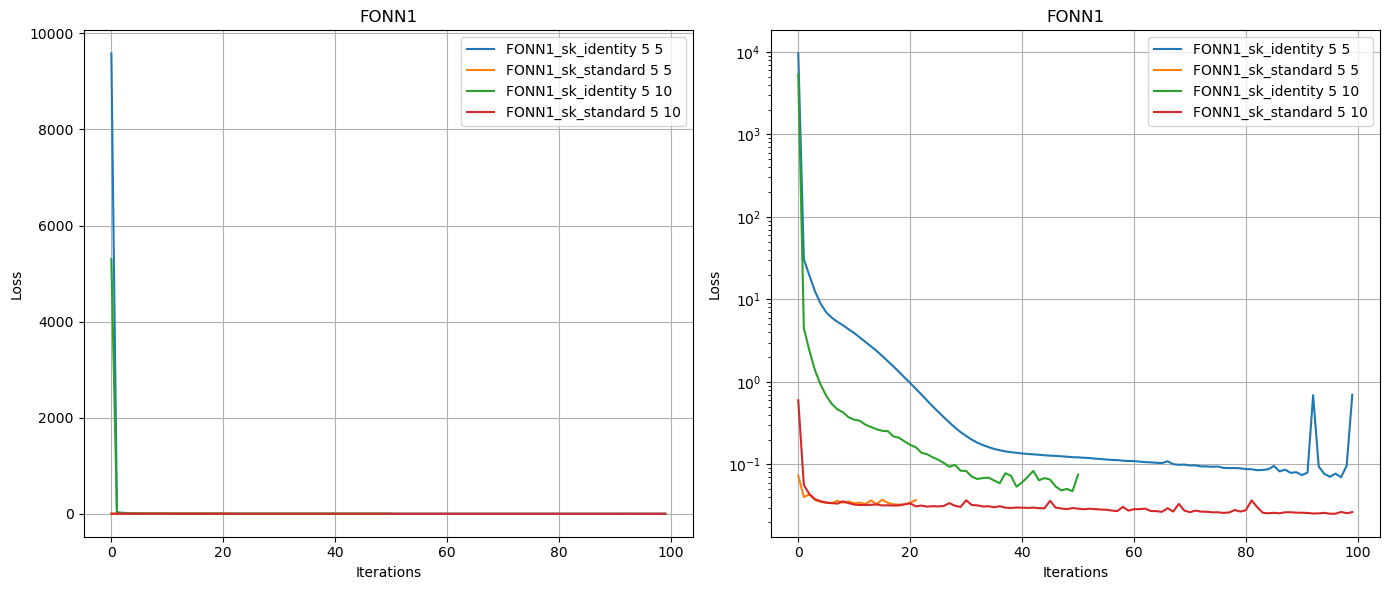

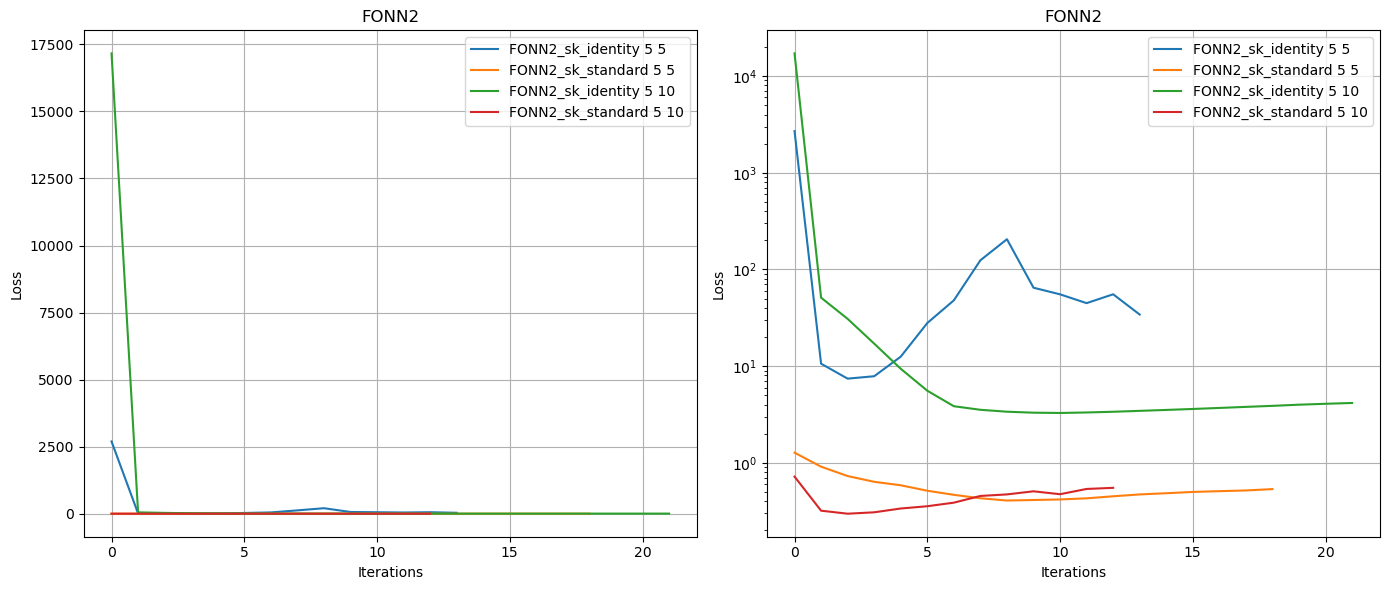

In [18]:
import matplotlib.pyplot as plt

plot_groups = {}
for model_name, model in models.items():
    if hasattr(model.best_estimator_['model'], 'loss_curve_'):
        key = model_name.split('_' if '_' in model_name else ' ')[0]
        if key not in plot_groups:
            plot_groups[key] = plt.subplots(1, 2, figsize=(14, 6))
        fig, (ax1, ax2) = plot_groups[key]
        plot_loss(model.best_estimator_['model'], ax1, ax2, model_name)

for group, plot in plot_groups.items():
    fig, (ax1, ax2) = plot
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.set_title(group)
    ax1.legend()
    ax1.grid(True)

    ax2.set_yscale('log')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title(group)
    ax2.legend()
    ax2.grid(True)

    fig.tight_layout()
    fig.show()

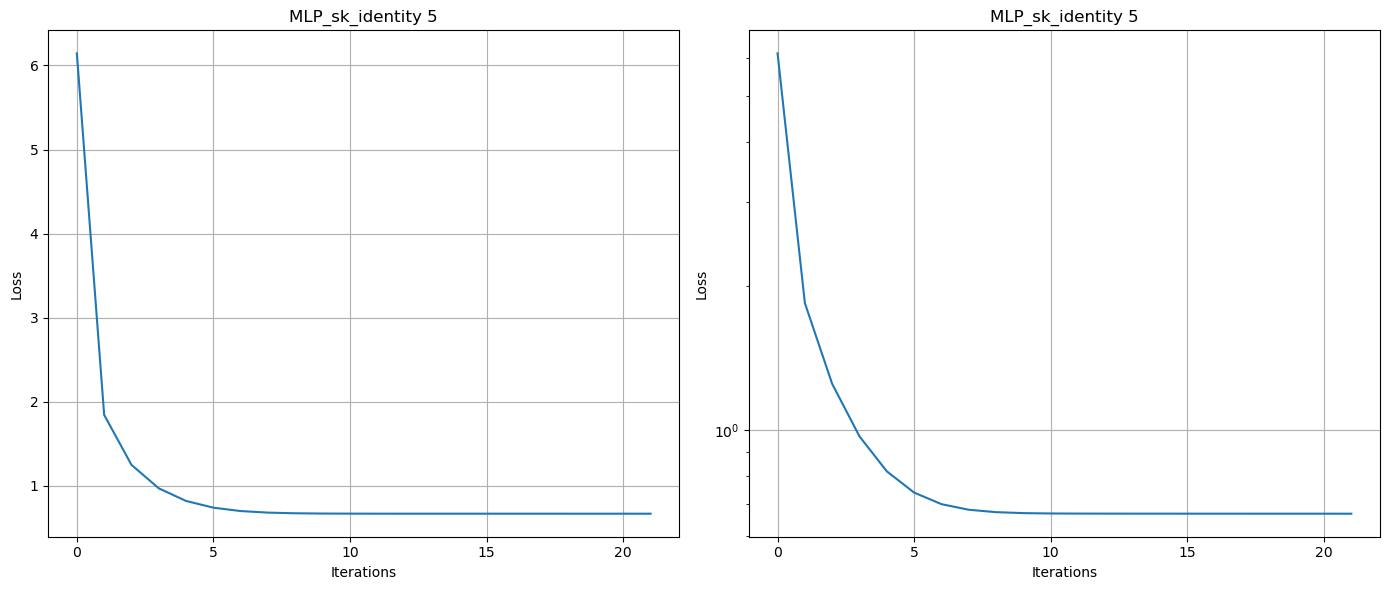

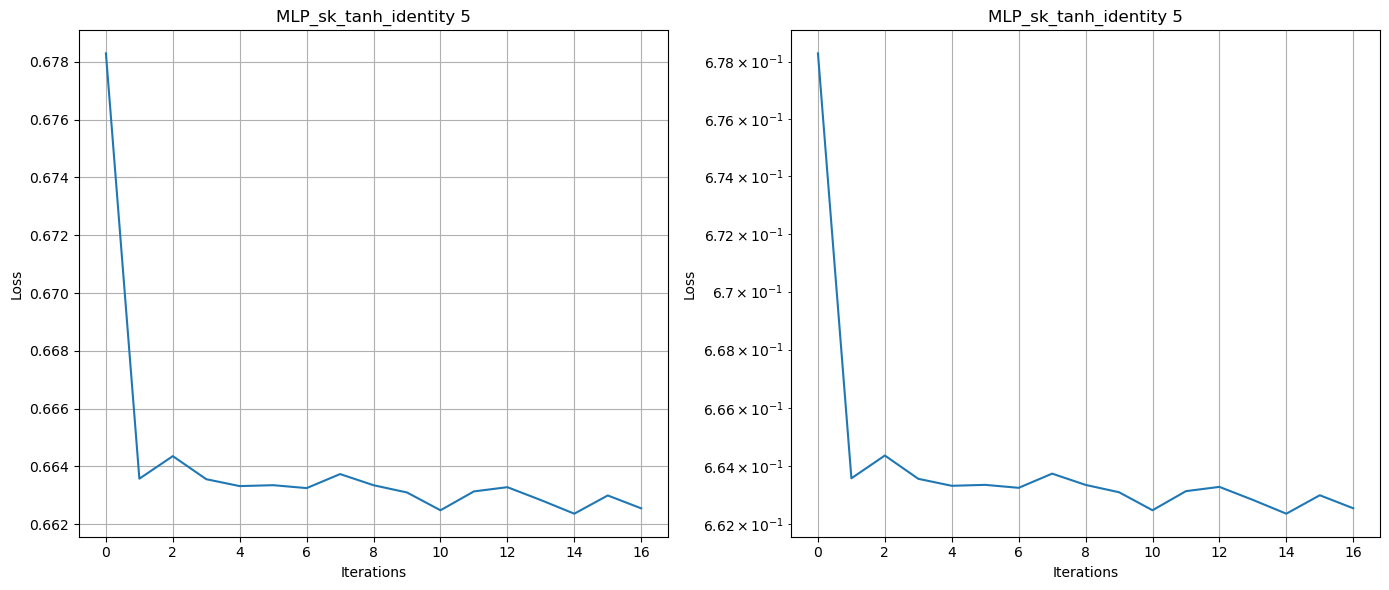

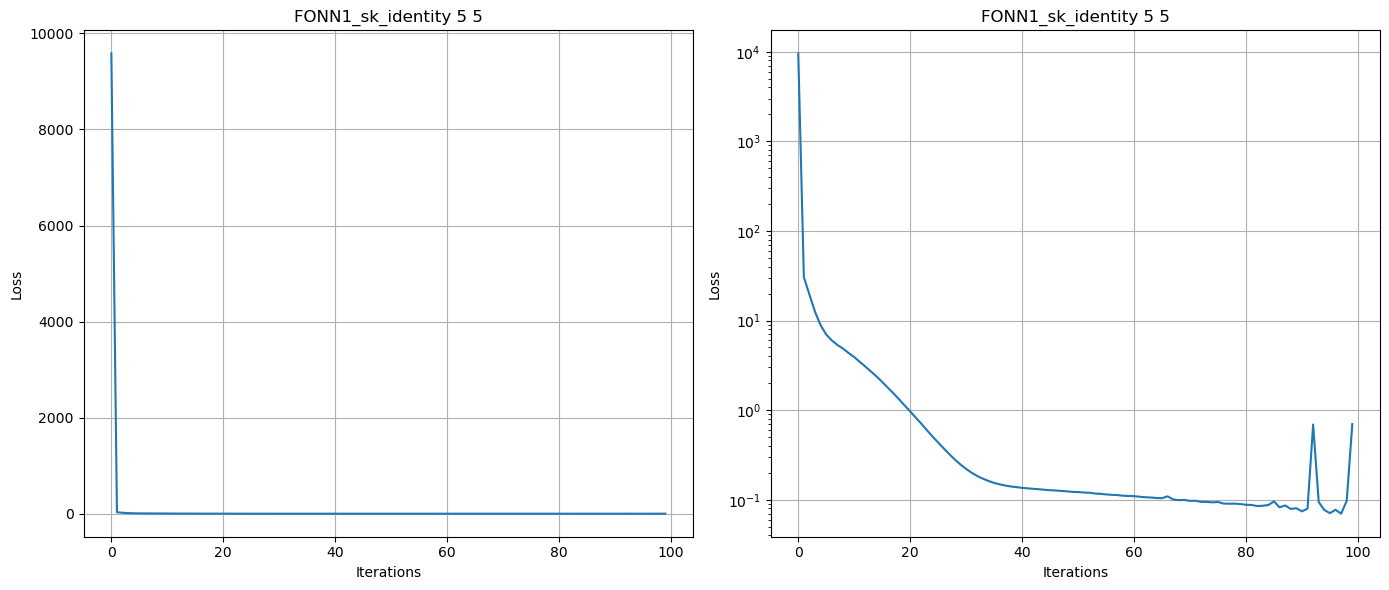

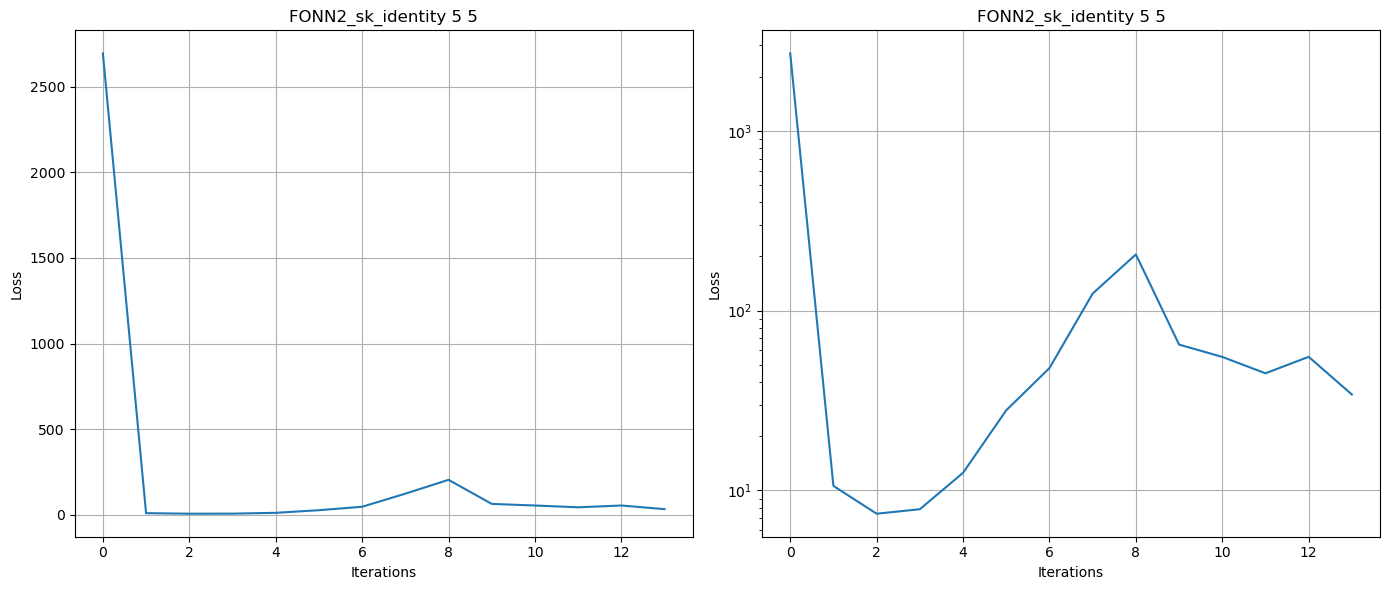

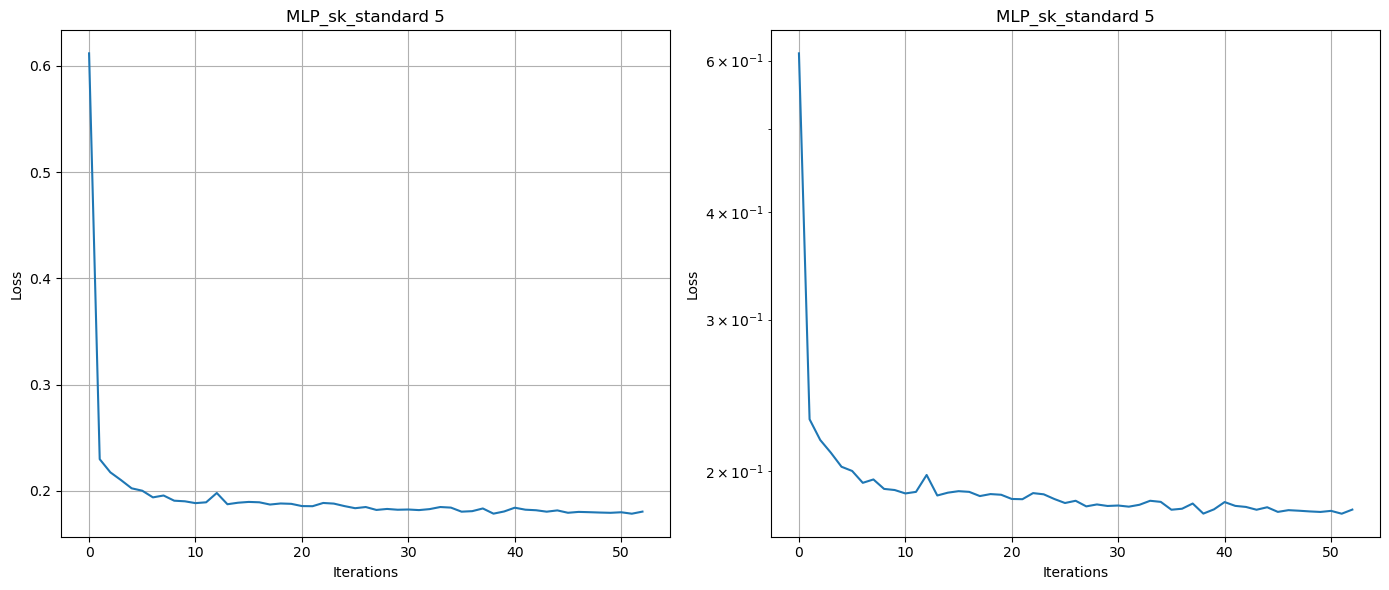

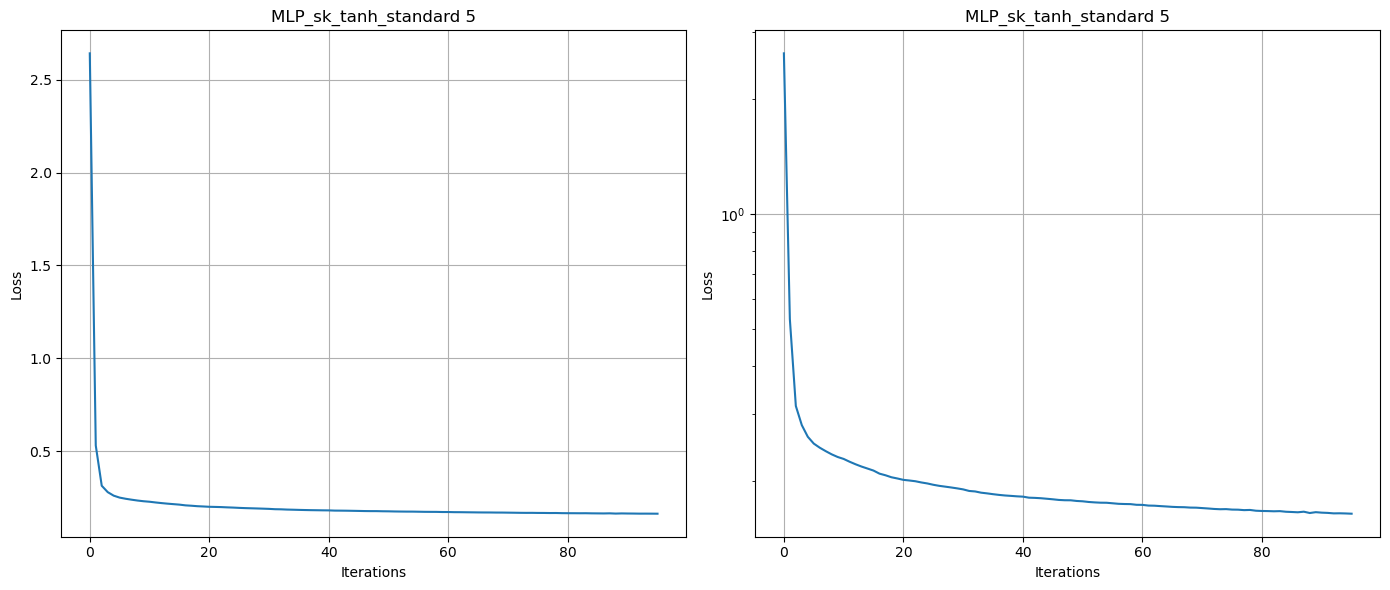

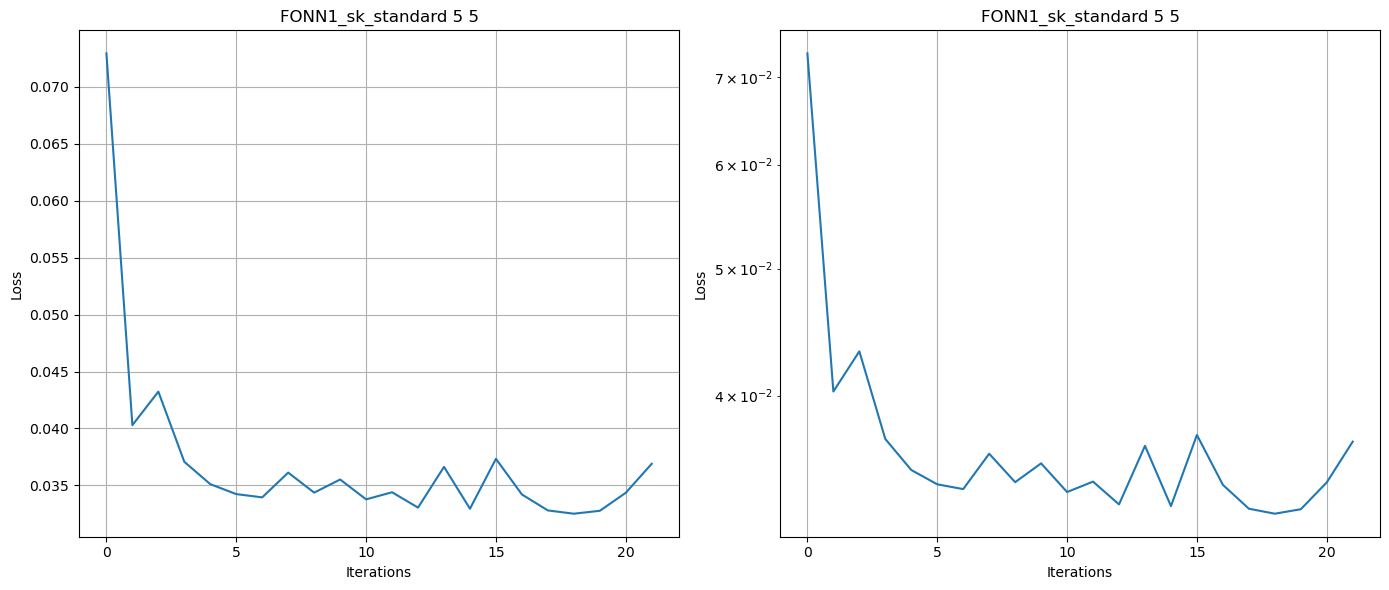

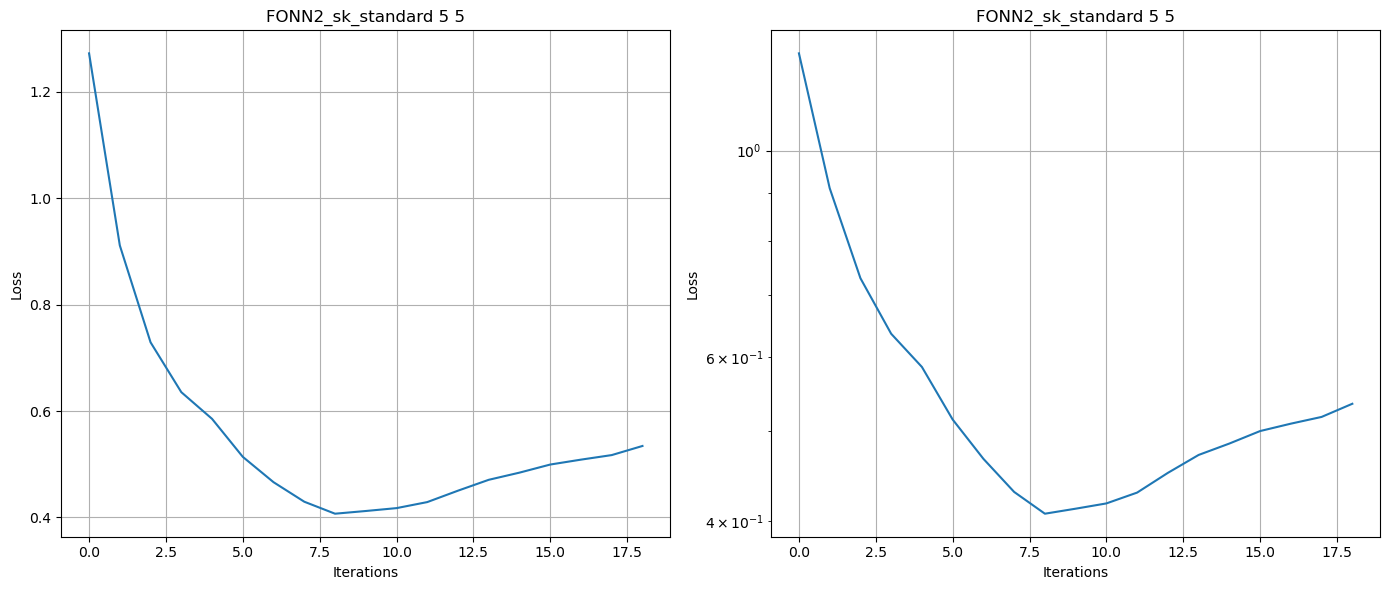

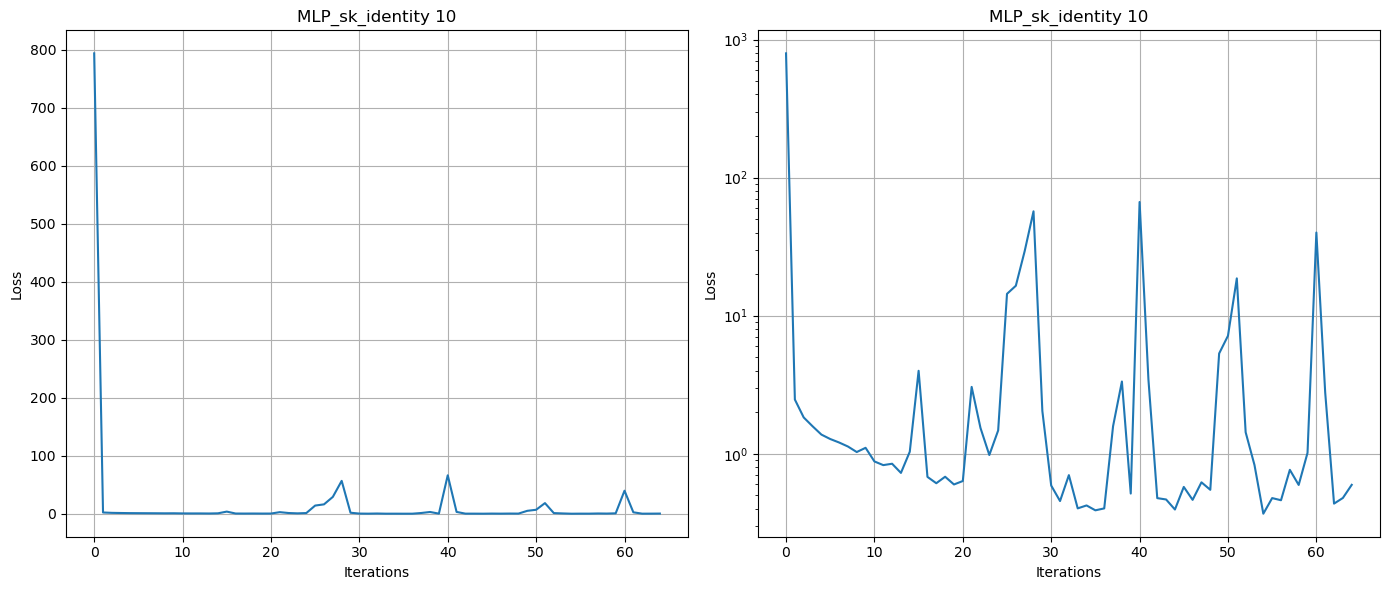

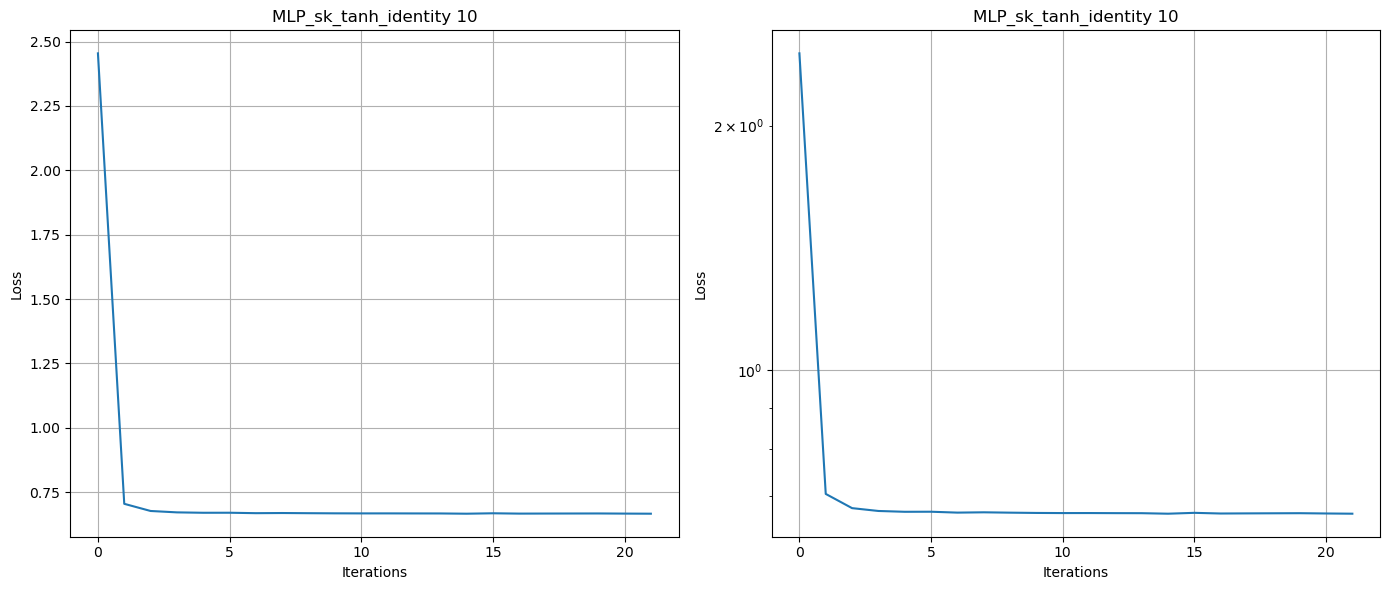

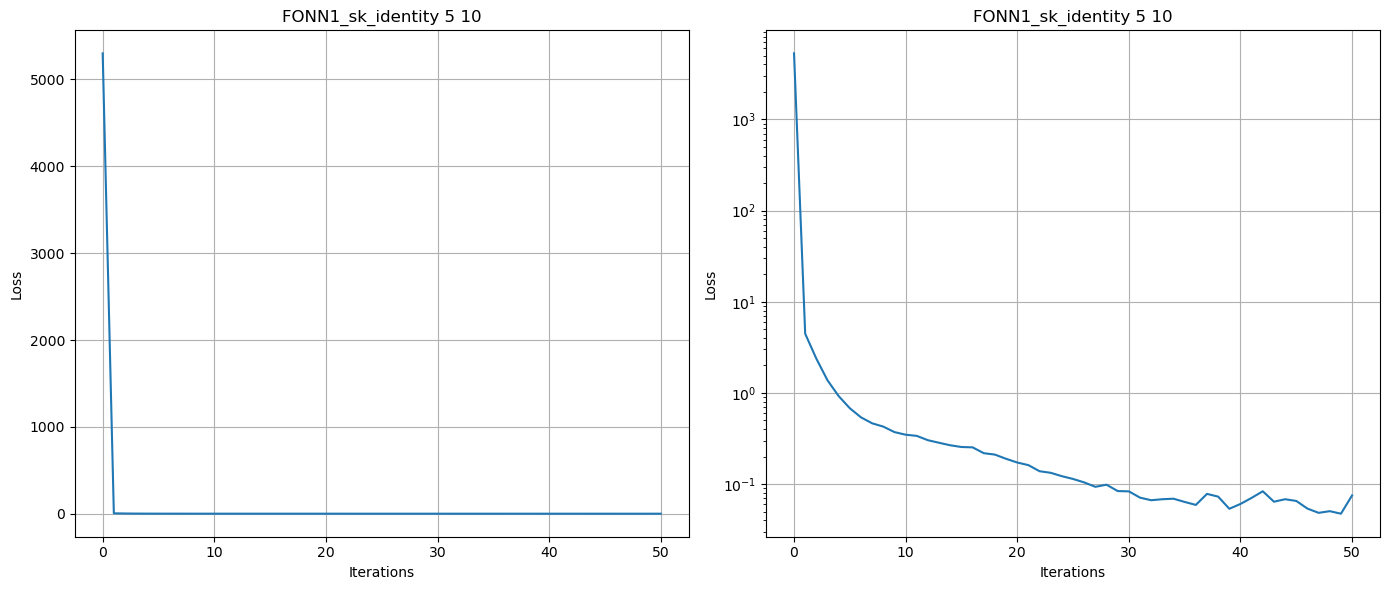

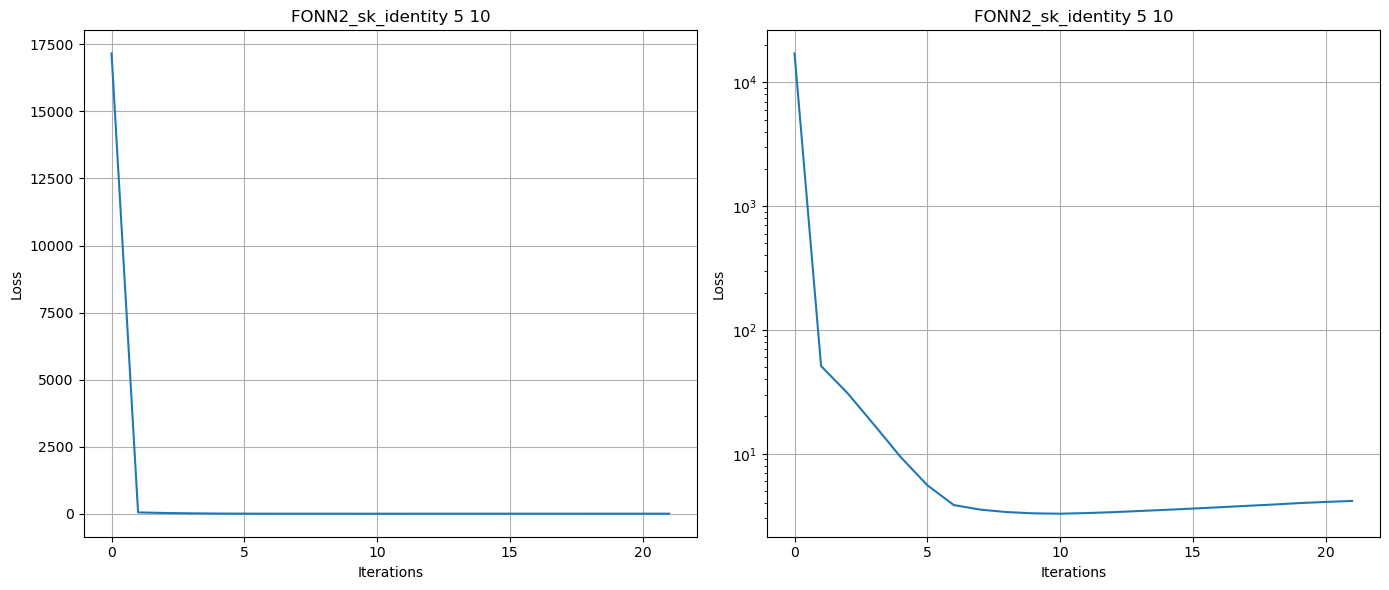

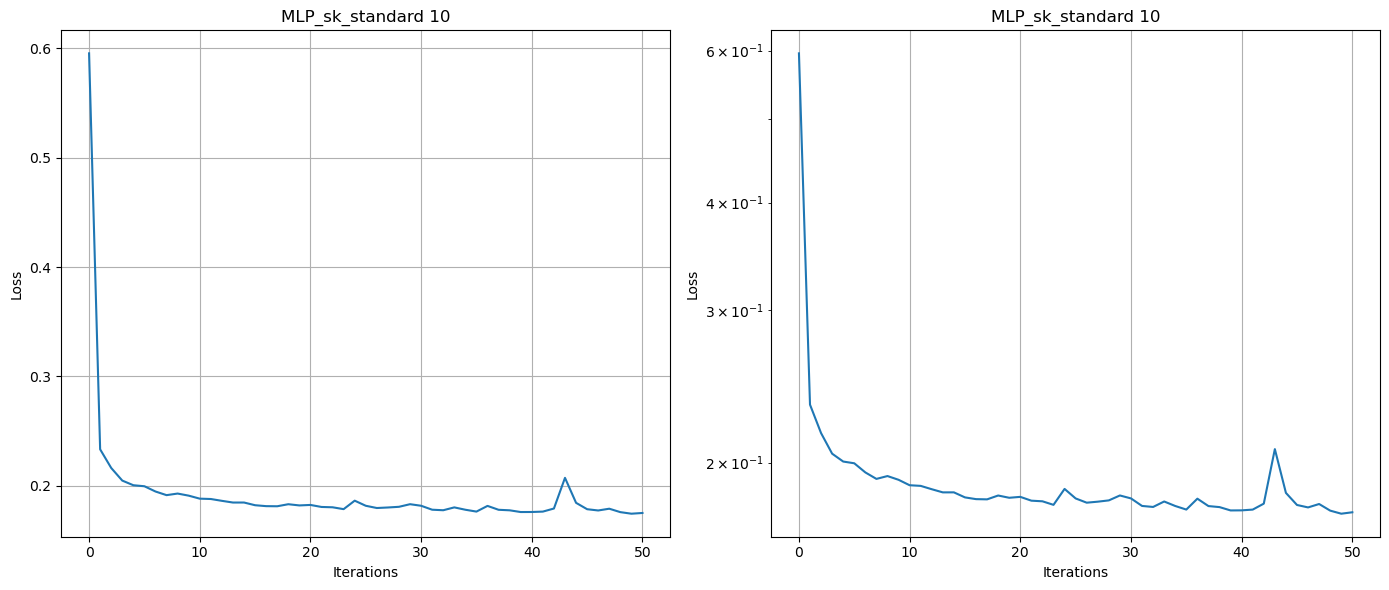

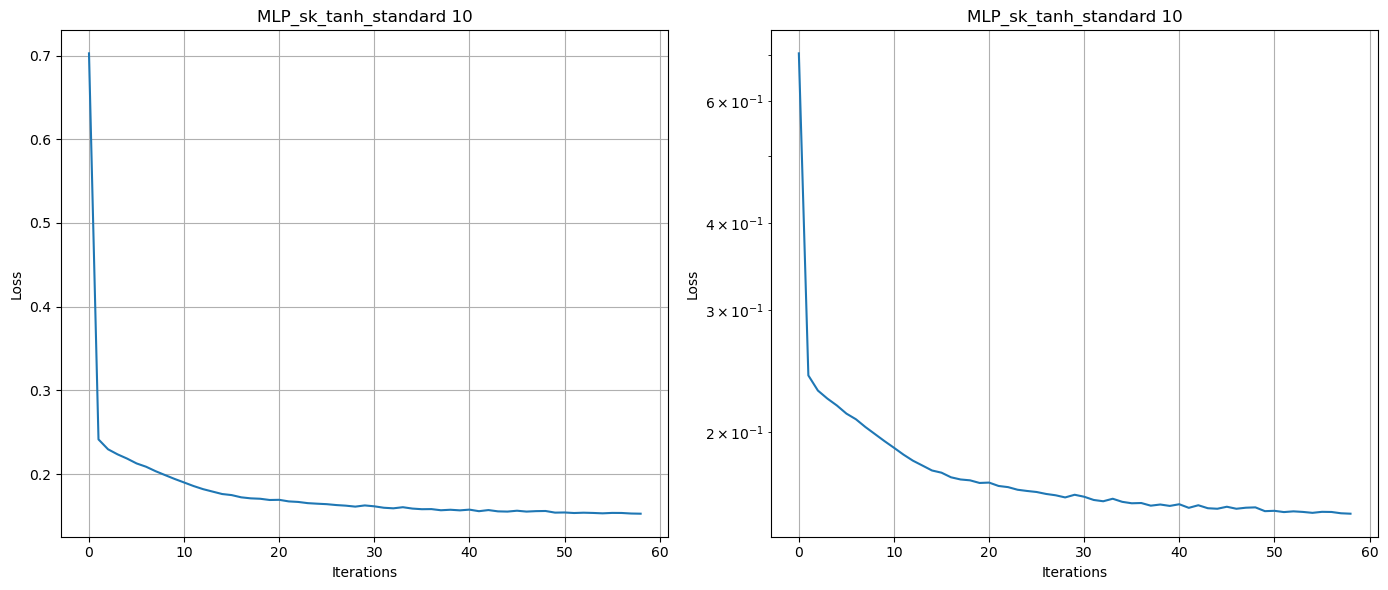

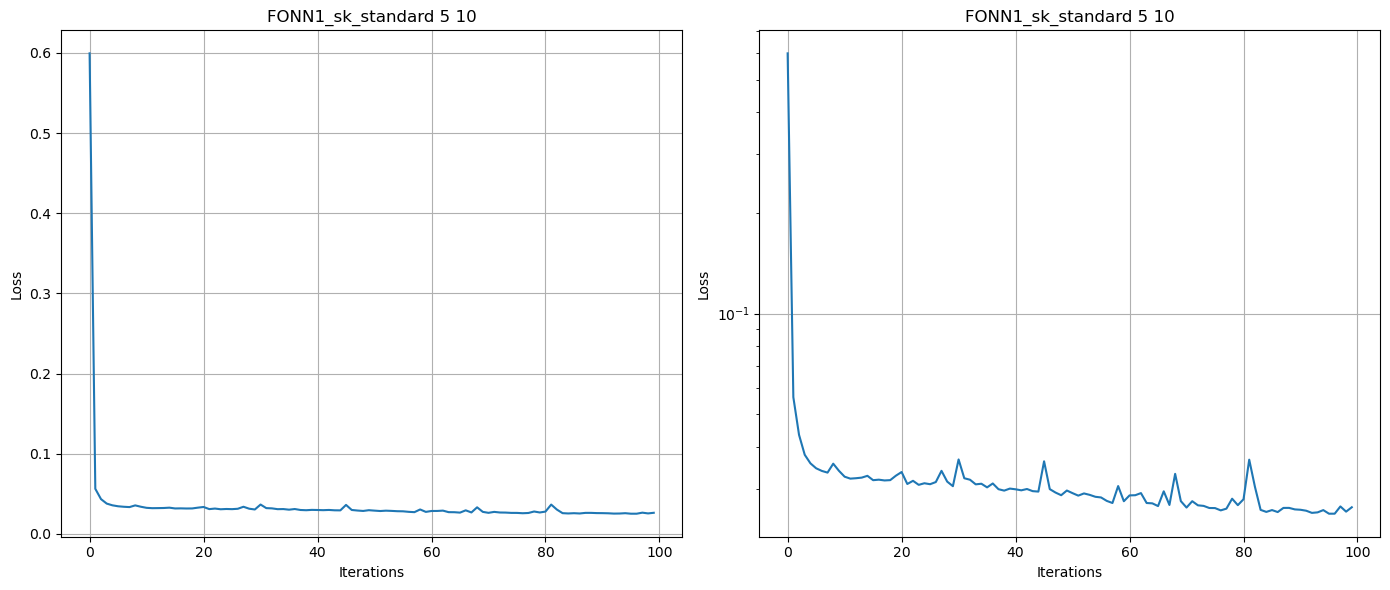

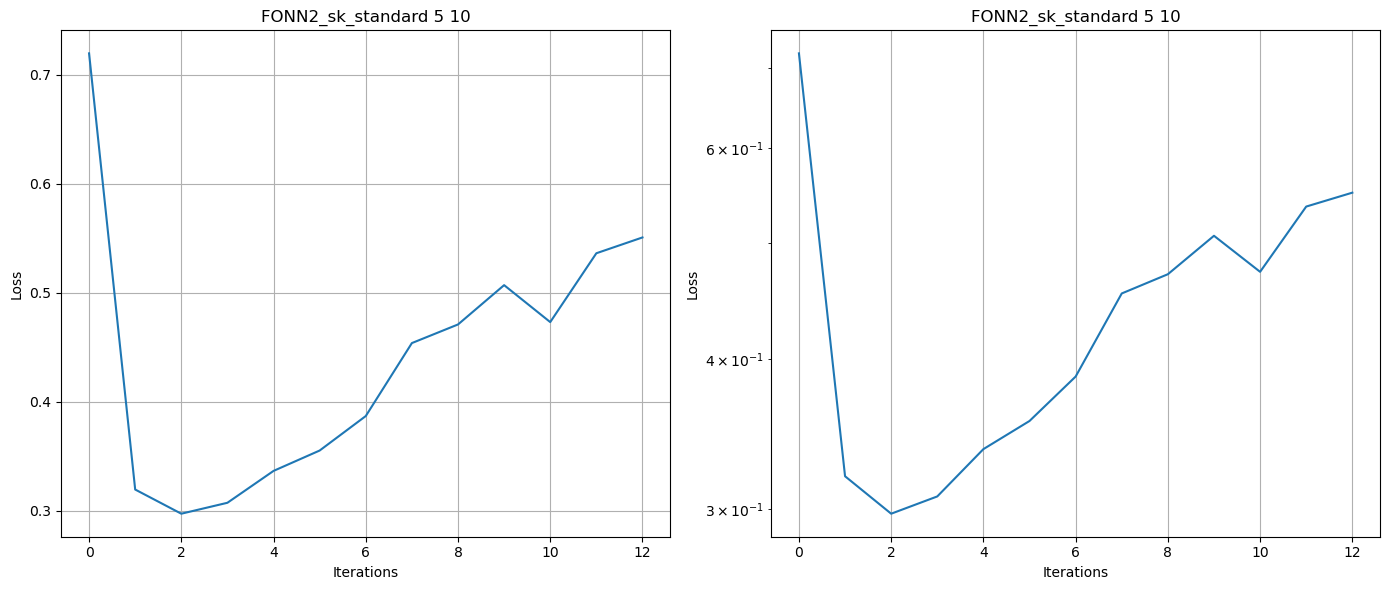

In [19]:
for model_name, model in models.items():
    if hasattr(model.best_estimator_['model'], 'loss_curve_'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        plot_loss(model.best_estimator_['model'], ax1, ax2, model_name)
        ax1.set_title(model_name)
        ax2.set_title(model_name)
        fig.tight_layout()
        fig.show()